Here I am playing around with the analysis of the atomistic simulations of some string confouts

I would like to check out sugar coordination, and how the gates are moving. In the visual inspection I can't see much

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MDAnalysis as mda
from numpy.linalg import norm
from MDAnalysis.analysis import rms 
import math

from MDAnalysis.analysis import distances as d
import sys
sys.path.append('../../../string/analysis/scripts')
import gate_functions
import pandas as pd

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


# Relevant functions
These are copied from TM7b_TM10b script, and just modified a bit here

In [2]:
def get_TM10_RMSD(u, skip, backbone=True): 
    # let's keep the same ref here as used in the histo analysis
    ref = mda.Universe('../../../string/analysis/textfiles_out/TM10_RMSD/testing_RMSD/OUT.start.gro')
    if backbone:
        selection='backbone'
    else:
        selection='resid 365-395'
        
        

    R = rms.RMSD(reference = ref, 
            atomgroup = u, 
            select = selection, 
            center = True, 
            groupselections = ['resid 385-395']
           )
        
    R.run(step=skip)
    rmsd = R.rmsd

        
    return rmsd[:,3]

In [3]:
def theta_of_angle(u, s1, s2, s3):
    A = u.select_atoms(s1).center_of_geometry()
    B = u.select_atoms(s2).center_of_geometry()
    C = u.select_atoms(s3).center_of_geometry()

    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)


def get_angle(u, set_name, skip, backbone = True):
    ## preprocessing
    if backbone:
        backbone = ' and name CA'
    else:
        backbone = ''
    
    sets_sels = {'set1':['283-285', '290-292', '298-300'],\
                 'set2':['284', '291', '299']
                }
    sels = sets_sels[set_name]
    
        
    theta_u = []
    for ts in u.trajectory[::skip]:
        theta = theta_of_angle(u, s1 = f'resid {sels[0]}{backbone}', 
                        s2 = f'resid {sels[1]}{backbone}', 
                        s3 = f'resid {sels[2]}{backbone}')

        theta_u.append(theta)        

    return theta_u

In [29]:
def get_salt_bridge(u,skip):
    ## first bridge
    bridge1 = []
    bridge2 = []
    
    #arg = u.select_atoms('resid 152 and name NE HE NH1 NH2 HH11 HH12 HH21 HH22')
    #glu = u.select_atoms('resid 394 and name OE1 OE2')
    
    bridge1_res1 = u.select_atoms('resid 145 and resname GLU and name OE1 OE2')
    bridge1_res2 = u.select_atoms('resid 401 and resname ARG and name NE HE NH1 NH2 HH11 HH12 HH21 HH22')  
    #R401 for state dependent, 91 for always
        
    bridge2_res1 = u.select_atoms('resid 394 and resname GLU and name OE1 OE2')
    bridge2_res2 = u.select_atoms('resid 152 and resname ARG and name NE HE NH1 NH2 HH11 HH12 HH21 HH22') 
    #R152 for state dependent, R334 for always
    
    #print('this is currently state dependent')
    
    for ts in u.trajectory[::skip]:
        bridge1.append(np.min(d.distance_array(bridge1_res1.positions, bridge1_res2.positions)))
        bridge2.append(np.min(d.distance_array(bridge2_res1.positions, bridge2_res2.positions)))
    
    bridge1 = np.array(bridge1)
    bridge2 = np.array(bridge2)
    
    #return bridge1, bridge2
    bridges = np.vstack((bridge1, bridge2))
    bridges = np.mean(bridges, axis=0)
    return bridges

In [5]:
def get_weighted_cv_dist(u):
    
    ## LDA cvs

    lda_cvs=[6124,2571,6601,1228,7356,3383,163,163,\
             6027,5129,6660,1128,4974,2807,2982,1815,\
             4984,4792,5628,4652,3047,1813,5270,2470,\
             6398,1445,6727,1124,3041,1807,6660,1178,\
             5096,2648,6191,2512,6337,3368,6607,1236]

    weights_dict_cv1 = {'x2':0.05481716895658035,\
                        'x4':0.06521745712833378,\
                        'x6':0.07157146634160952,\
                        'x9':0.08604687391019761,\
                        'x11':0.10789821030652916,\
                        'x14':0.13012176179638452,\
                        'x15':0.13297719079893605,\
                        'x16':0.13308741702095686,\
                        'x20':0.2182624537404722}

    weights_dict_cv2 = {'x1':0.0465977568373212,\
                        'x3':0.04763636826996152,\
                        'x5':0.0614126467079626,\
                        'x7':0.07291782865993626,\
                        'x8':0.07366471306275921,\
                        'x10':0.08547133618978661,\
                        'x12':0.10253561347208211,\
                        'x13':0.1090769579491046,\
                        'x17':0.12702038305559357,\
                        'x18':0.133249691342014, \
                        'x19':0.14041670445347829}
    
    
    selection1=[]
    selection2=[]
    
    index_list=lda_cvs

    darko_gro = mda.Universe('../../../string/analysis/darko_out_open.gro')
    for n,index in enumerate(index_list):
        sel=darko_gro.select_atoms(f'index {index-1}')
        if n%2==0:
            if n == 4 and index_list == lda_cvs:
                selection1.append(u.select_atoms(f'resname VAL and resid {sel.residues.resids[0]-7} and name CG1'))
            else:
                selection1.append(u.select_atoms(f'resname {sel.residues.resnames[0]} and \
                resid {sel.residues.resids[0]-7} and name {sel.names[0]}'))

        
        elif n%2==1:
            if n == 11 and index_list == lda_cvs:
                selection2.append(u.select_atoms(f'resname LEU and resid {sel.residues.resids[0]-7} and name N'))
            else:
                selection2.append(u.select_atoms(f'resname {sel.residues.resnames[0]} and \
                resid {sel.residues.resids[0]-7} and name {sel.names[0]}'))
            
            
            
    ### you need to split up the dists into two cvs, so we have to have two distances (cv1 and cv2)  
    ## this is just to tell you where in distances_cv1 or distances_cv2 you should put your val
    ## since n will go up to 9, but the distances is only 5 long
    
    
    ## LDA CVS
    weights_dict_distance_position={'x1':0, 'x2':0, 'x3':1, 'x4':1, 'x5':2, \
                                   'x6':2, 'x7':3, 'x8':4, 'x9':3, 'x10':5, \
                                   'x11':4, 'x12':6, 'x13':7, 'x14':5, 'x15':6, \
                                   'x16':7, 'x17':8, 'x18':9, 'x19':10, 'x20':8}
    
    
    distances_cv1 = np.zeros((int(len(weights_dict_cv1.keys())), u.trajectory.n_frames))
    distances_cv2 = np.zeros((int(len(weights_dict_cv2.keys())), u.trajectory.n_frames))
    
    for ts in u.trajectory:
        n=0
        for sel1,sel2 in zip(selection1, selection2):
            raw_dists=d.distance_array(sel1.positions, sel2.positions)#/10  #needs NM!!
            raw_dists=1/(1+math.e **(2*raw_dists-8.0))
            #print(raw_dists, raw_dists2)
            
        ## because the CV's have been named x1, x2 , etc you should associate your distance for this pair with
    ### an x. The order is already correct, so first dist pair is x1, then x2.
    ### The weights per cv are associated with an x_name
    ### when putting into the distances_cv? array, you will go to the position that "x1" should be (0), 
    ### and the position
    ### for that frame, and at this spot you apply the weights associated with 'x1' to the distance
    
    ## so for 10 indexes and a traj of 600 frames, you'll have a distances_cv1 of [5,600] and distances_cv2 of [5,600]
            x_name = ('x'+str(n+1))
            if x_name in weights_dict_cv1.keys():
                distances_cv1[weights_dict_distance_position[x_name],ts.frame]=weights_dict_cv1[x_name] * raw_dists
            elif x_name in weights_dict_cv2.keys():
                distances_cv2[weights_dict_distance_position[x_name],ts.frame]=weights_dict_cv2[x_name] * raw_dists
            n=n+1
  


    ### as we need weighted sum for each cv
    distances_cv1 = np.sum(distances_cv1, axis = 0)
    distances_cv2 = np.sum(distances_cv2, axis = 0)
    return distances_cv1, distances_cv2

# load atom sims

In [6]:
u1=mda.Universe('../../OUT/initial_run_for_demyst/equilibration/minim.gro',\
                '../../OUT/initial_run_for_demyst/production/GLUT5_out.0_520ns.skip250.xtc')
u2=mda.Universe('../../OUT-OCC/equilibration/minim.gro',\
                '../../OUT-OCC/production/GLUT5_out_occ.0_296ns.skip250.xtc')
u3=mda.Universe('../../OCC/equilibration/minim.gro',\
                '../../OCC/production/GLUT5_occ.0_543ns.skip5.xtc')
u4=mda.Universe('../../IN-OCC/equilibration/minim.gro',\
                '../../IN-OCC/production/GLUT5_in_occ.0_200ns.skip250.xtc')
u5=mda.Universe('../../IN/initial_run_for_demyst/equilibration/minim.gro',\
                '../../IN/initial_run_for_demyst/production/GLUT5_in.0_550ns.skip250.xtc')
uni_crystals_sims={'out_open':u1,\
             'out_occ':u2,\
             'occ':u3,\
             'in_occ':u4,\
             'in_open':u5}


indir='../../../string/analysis/ref_models_protonly'
u1=mda.Universe(f'{indir}/OUT.start.protonly.gro')
u2=mda.Universe(f'{indir}/OUT-OCC.start.protonly.gro')
u3=mda.Universe(f'{indir}/OCC.start.protonly.gro')
u4=mda.Universe(f'{indir}/IN-OCC.start.protonly.gro')
u5=mda.Universe(f'{indir}/IN.start.protonly.gro')
uni_crystals_strs={'out_open':u1,\
             'out_occ':u2,\
             'occ':u3,\
             'in_occ':u4,\
             'in_open':u5}

# load my histos, and choose which to examine

In [7]:
histo_conds = {'in_occ_high_string':['552-10-06','552-10-19', '552-10-23'],\
              'in_occ_low_string':['300-11-12', '551-11-16', '551-11-24'],\
              'outward_open':['552-1-2', '552-1-29','552-2-1'],\
              'occluded_full_symmetry':['523-6-10','525-6-19'],\
              'occluded_PfHT':['487-7-14', '524-7-27']}

path_conds = {'in_occ_high_string':'../../controls_string/inward_occluded/in_occ_high_string',\
             'in_occ_low_string':'../../controls_string/inward_occluded/in_occ_low_string',\
             'outward_open':'../../controls_string/outward_open',\
             'occluded_full_symmetry':'../../controls_string/occluded/occ_full_symmetry',\
             'occluded_PfHT':'../../controls_string/occluded/occ_PfHT'}

grid_num_conds = {'in_occ_high_string':730,\
                 'in_occ_low_string':353,\
                 'outward_open':2223,\
                 'occluded_full_symmetry':930,\
                 'occluded_PfHT':823}  

<a id='top'></a>
## Here you can choose which condition to measure

In [8]:
cond = 'in_occ_high_string'

uni_histos = {}

for histo in histo_conds[cond]:
    u=mda.Universe(f'{path_conds[cond]}/{histo}/confout.gro',\
                  f'{path_conds[cond]}/{histo}/{histo}.all.skip250.xtc')
    
    uni_histos[histo]=u

# Get dicts of atom sims

Can toggle here between `uni_crystal_strs` and `uni_crystal_sims` depending on what you want to see

In [35]:
atom_uni = uni_crystals_strs

tm10_atom={}
for histo in atom_uni.keys():
    tm10_atom[histo] = get_TM10_RMSD(u=atom_uni[histo], skip=1)
    
tm7_atom={}
for histo in atom_uni.keys():
    tm7_atom[histo] = get_angle(u=atom_uni[histo], skip=1, set_name='set1')
    
salt_br_atom={}
for histo in atom_uni.keys():
    salt_br_atom[histo] = get_salt_bridge(u=atom_uni[histo], skip=1)

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/coordinates/base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:710: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


# get dicts of each grid

After trying a few different ways, I feel the best is still to just call a function **once** and save it to a dict or something, and then you can slice it how you wish in the function. This is much faster and I tend to run over and over and over again, so let's just make a dict for each function, it's not so many

In [10]:
gate_EC = [(30,37), (289,295)]
gate_IC = [(136,145), (386,394)]

gates_histos={}
IC_all = np.zeros((3,700))
EC_all = np.zeros((3,700))
time_all = np.zeros((3,700))

IC_all[IC_all==0] = np.nan
EC_all[EC_all==0] = np.nan
time_all[time_all==0] = np.nan

for n,histo in enumerate(histo_conds[cond]):
    EC, IC = gate_functions.make_gate_arr(uni_histos[histo], gate_EC=gate_EC, gate_IC=gate_IC)
    EC = EC/10
    IC = IC/10
    time=np.arange(0,len(EC))
    gates_histos[histo] = np.array([EC,IC,time])
    IC_all[n][:len(IC)] = IC
    EC_all[n][:len(EC)] = EC
    time_all[n][:len(time)] = time

returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists


In [30]:
tm10_histos={}
for histo in histo_conds[cond]:
    tm10_histos[histo] = get_TM10_RMSD(u=uni_histos[histo], skip=1)
    
tm7_histos={}
for histo in histo_conds[cond]:
    tm7_histos[histo] = get_angle(u=uni_histos[histo], skip=1, set_name='set1')
    
salt_br_histos={}
for histo in histo_conds[cond]:
    salt_br_histos[histo] = get_salt_bridge(u=uni_histos[histo], skip=1)

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:710: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


# Check how EC and IC are moving around on FES space
Currently, you just choose one of the replicas and plot that with `control_replica` variable

In [364]:
F_MSM = np.load('../../../string/string_sims/TMD_initial_path/influx_BFRU_gate_CV/F_MSM.npy')
extent_MSM = np.load('../../../string/string_sims/TMD_initial_path/influx_BFRU_gate_CV/extent_MSM.npy')

Here you can choose which IC or EC gate space you could plot a KDE for

In [365]:
print(gates_histos.keys())

dict_keys(['552-10-06', '552-10-19', '552-10-23'])


In [366]:
control_replica='552-10-19'
[EC,IC,time] = gates_histos[control_replica]
#time

Text(0.5, 1.0, '552-10-19')

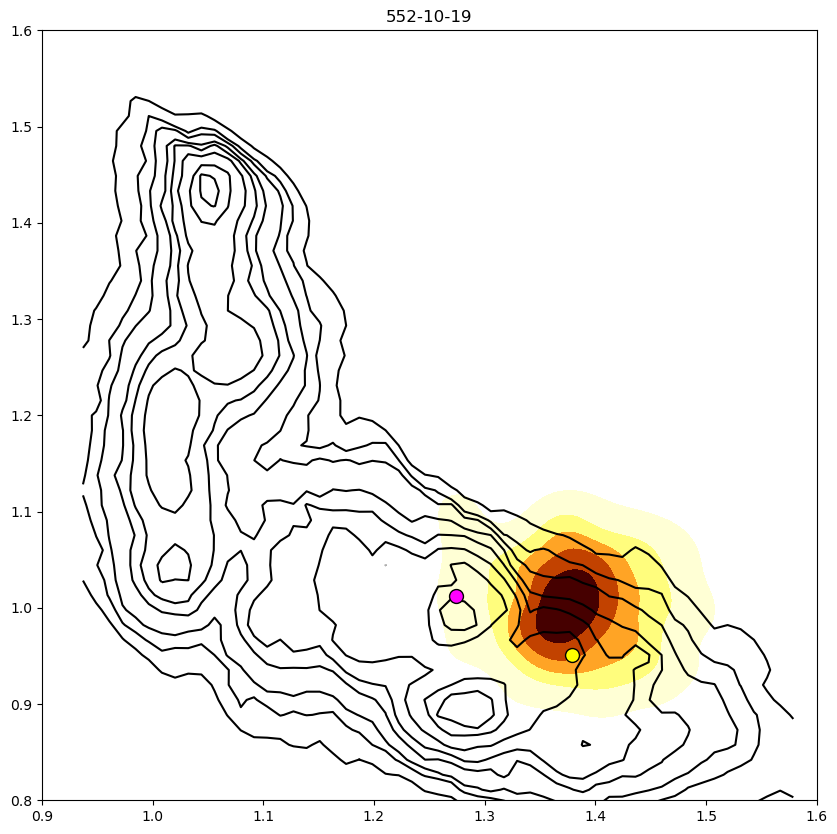

In [367]:
f,ax=plt.subplots(1,1,figsize=(10,10))

xlim = (0.9,1.6)
ylim = (0.8,1.6)


levelsf=np.linspace(0,15,30)
levels=[0,0.5,1,2,3,4,6,8,15]

#ax.contourf(F_MSM, extent=extent_MSM,
#            levels=levelsf,
#           vmin=0,vmax=10,cmap='RdYlBu_r' )
ax.contour(F_MSM, extent=extent_MSM, 
          levels=levels,
          vmin=0,vmax=10, colors='black')

skip=2
IC_s=IC[::skip]
EC_s=EC[::skip]
time_s=time[::skip]
#ax.scatter(IC_s, EC_s, c=time_s, cmap='spring',zorder=4)
ax.scatter(IC[0], EC[0], s=100, edgecolor='black', c='magenta',zorder=3)
ax.scatter(IC[-1], EC[-1], s=100, edgecolor='black', c='yellow',zorder=3)
sns.kdeplot(IC,y=EC,ax=ax,shade=True,cmap='afmhot_r', levels=6)
#sns.jointplot(IC,y=EC,ax=ax,cmap='afmhot_r', kind='kde')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title(control_replica)

# Plotting the overlap! 

As discussed with Claudia, you might be interested in measuring the overlap between **any** distribution. This could tell you how convered your sims are and give you more statistics than just saying the histogram is close to a dot

In [211]:
def plot_overlap(values1, values2, bin_sensitivity, ax,
                 ns_block_start1=None, ns_block_end1=None,
                ns_block_start2=None, ns_block_end2=None, xlim=None,ylim=None):
    '''
    Here, 'function' is any of the functions you have
    
    bin_sensitivity will tell you basically what # bins you have
    
    ns_block_start and ns_block_end will just dictate which chunks of simulation you want to check
    you do not have to put this if you dont want to, will automatically read whole sim
    
    skip will allow you to skip frames, which is useful when you are just playing with how you want the plots to look 
    '''
    
    values1=values1[ns_block_start1:ns_block_end1]
    values2=values2[ns_block_start2:ns_block_end2]
    
    ## need to find min and max of both plots to not cut off
    bin_min = np.min([np.min(values1), np.min(values2)]) - 0.2
    bin_max = np.max([np.max(values1), np.max(values2)]) + 0.2  
    
    # make a histo that gives you # bins based on the range dictated by your values
    height1, bin_edges1 = np.histogram(values1, bins = np.arange(bin_min, bin_max, bin_sensitivity))
    height2, bin_edges2 = np.histogram(values2, bins = np.arange(bin_min, bin_max, bin_sensitivity))
    
    
    ## normalize the heights so that the total AUC is 1. This is important because you want to ensure
    ### that when you measure overlap that it's a percentage
    height1 = height1/height1.sum()
    height2 = height2/height2.sum()
    
    alpha = 1
    xlim=(xlim)
    ylim=(ylim)
    ax.stairs(height1, bin_edges1)
    ax.stairs(height2, bin_edges2)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ### next - find the overlap. You stack the 2 dists on top of each other
    #### and find the minima per height
    overlap = np.vstack((height1,height2))
    overlap = np.min(overlap, axis = 0)
    ax.stairs(overlap, np.arange(bin_min, bin_max, bin_sensitivity), fill=True, alpha=0.5)
    
    
    print(f'returning overlap.sum ({np.round(overlap.sum(),4)}) which is total % of sims overlapping in this dist')
    return overlap.sum()


In [212]:
def overlap_blocking(control_replica, values1, values2, xlim, ylim, title, bin_sensitivity):
    u = uni_histos[control_replica]


    trajtime_ns = int(u.trajectory.totaltime/1000)
    block_size = 50
    window_size = 20

    f, ax = plt.subplots(nrows=int(np.floor(trajtime_ns/window_size))+1, ncols=1,\
                         figsize = (5,int(2*int(np.ceil(trajtime_ns/window_size)))))
    ax = np.ravel(ax)

    overlaps = []
    for n, start in enumerate(np.arange(0,trajtime_ns, window_size)):
        end = start + block_size
        print(start,end,n)
        start = int(start)
        end = int(end)

        if end > trajtime_ns:
            end = trajtime_ns

        overlaps.append(plot_overlap(values1=values1,
                                     values2=values2,
                                     bin_sensitivity=bin_sensitivity,
                                     ax=ax[n],
                                     ns_block_start1=start,
                                     ns_block_end1=end,
                                     xlim=xlim,
                                     ylim=ylim

                                    ))

        ax[n].set_title(f'{title} grid {grid_num_conds[cond]} vs {start}ns to {end}ns')


        ### after you do the final plot, stop. If you don't have this
        ## the loop will go once more, because the window size is smaller than the
        ### block size (so you would have 220-254, and then 240-254 which is redundant)
        if end == trajtime_ns:
            break


    ax[-1].plot(overlaps)
    plt.tight_layout()
    plt.show()

Just to keep things a bit organized here, first I will calculate whatever I want to do for my relevant grid. Could also put atom sim here

In [213]:
grid_indir = f'../../../string/analysis/confout_files/FES_grids_confouts/influx_BFRU_gate_CV/histogram_{grid_num_conds[cond]}'
u_grid = mda.Universe(f'{grid_indir}/FES_grid_all.start.protonly.pdb',
                      f'{grid_indir}/FES_grid_all.protonly.cluster.fit.xtc')

tm10_grid = get_TM10_RMSD(u_grid, skip=1)
tm7_grid = get_angle(u_grid, skip=1, set_name='set1')
salt_br_grid = get_salt_bridge(u_grid, skip=1)

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:710: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


In [224]:
control_replica = '551-11-24'

0 50 0
returning overlap.sum (0.811) which is total % of sims overlapping in this dist
20 70 1
returning overlap.sum (0.851) which is total % of sims overlapping in this dist
40 90 2
returning overlap.sum (0.952) which is total % of sims overlapping in this dist
60 110 3
returning overlap.sum (0.742) which is total % of sims overlapping in this dist
80 130 4
returning overlap.sum (0.487) which is total % of sims overlapping in this dist
100 150 5
returning overlap.sum (0.327) which is total % of sims overlapping in this dist
120 170 6
returning overlap.sum (0.347) which is total % of sims overlapping in this dist
140 190 7
returning overlap.sum (0.347) which is total % of sims overlapping in this dist
160 210 8
returning overlap.sum (0.427) which is total % of sims overlapping in this dist
180 230 9
returning overlap.sum (0.407) which is total % of sims overlapping in this dist
200 250 10
returning overlap.sum (0.387) which is total % of sims overlapping in this dist
220 270 11
returni

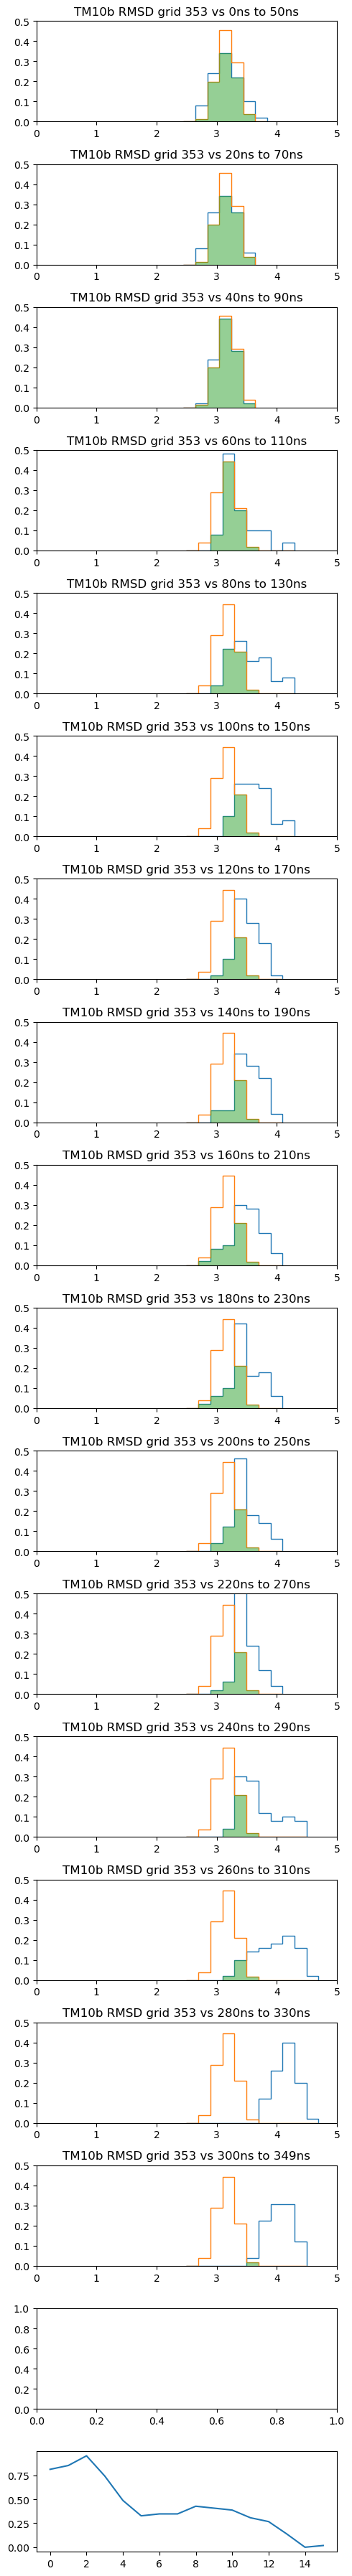

In [225]:
overlap_blocking(control_replica=control_replica,
                values1=tm10_histos[control_replica],
                values2=tm10_grid,
                xlim=(0,5),
                ylim=(0,0.5),
                title='TM10b RMSD',
                bin_sensitivity=0.2)

0 50 0
returning overlap.sum (0.215) which is total % of sims overlapping in this dist
20 70 1
returning overlap.sum (0.0862) which is total % of sims overlapping in this dist
40 90 2
returning overlap.sum (0.0503) which is total % of sims overlapping in this dist
60 110 3
returning overlap.sum (0.0312) which is total % of sims overlapping in this dist
80 130 4
returning overlap.sum (0.0321) which is total % of sims overlapping in this dist
100 150 5
returning overlap.sum (0.0321) which is total % of sims overlapping in this dist
120 170 6
returning overlap.sum (0.034) which is total % of sims overlapping in this dist
140 190 7
returning overlap.sum (0.034) which is total % of sims overlapping in this dist
160 210 8
returning overlap.sum (0.0356) which is total % of sims overlapping in this dist
180 230 9
returning overlap.sum (0.0356) which is total % of sims overlapping in this dist
200 250 10
returning overlap.sum (0.0356) which is total % of sims overlapping in this dist
220 270 11

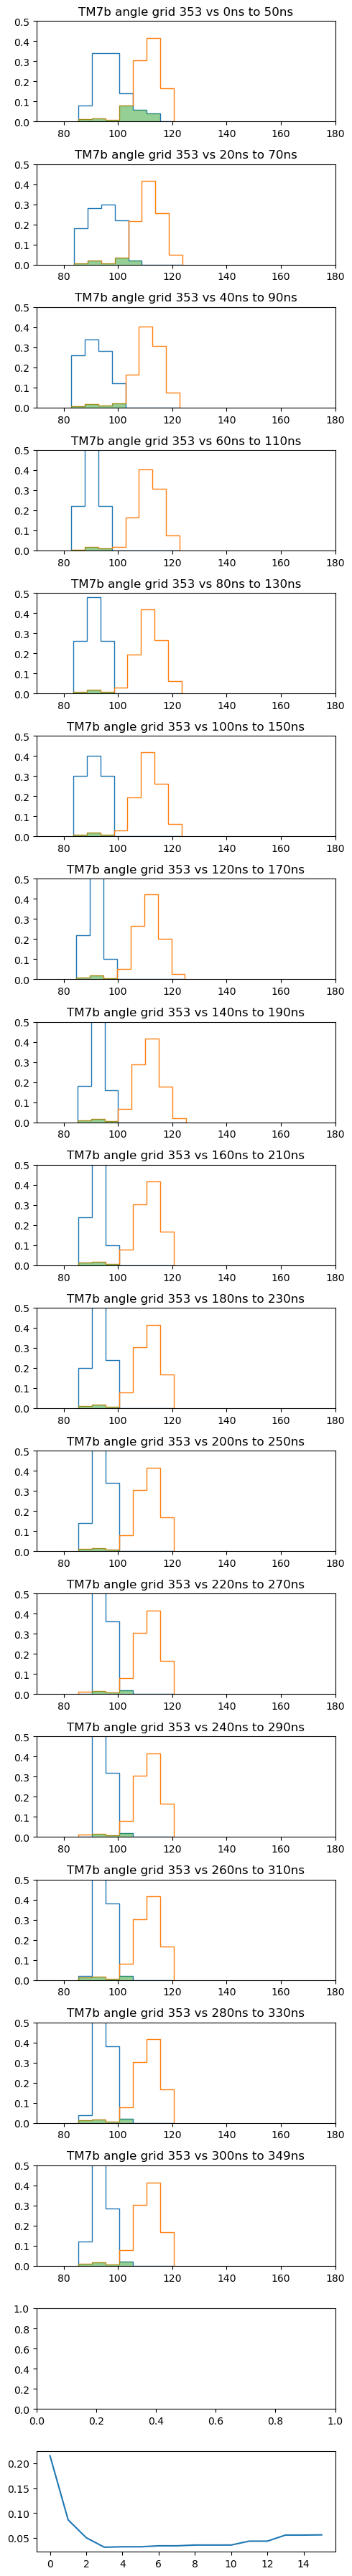

In [226]:
overlap_blocking(control_replica=control_replica,
                values1=tm7_histos[control_replica],
                values2=tm7_grid,
                xlim=(70,180),
                ylim=(0,0.5),
                title='TM7b angle',
                bin_sensitivity=5)

0 50 0
returning overlap.sum (0.345) which is total % of sims overlapping in this dist
20 70 1
returning overlap.sum (0.15) which is total % of sims overlapping in this dist
40 90 2
returning overlap.sum (0.129) which is total % of sims overlapping in this dist
60 110 3
returning overlap.sum (0.13) which is total % of sims overlapping in this dist
80 130 4
returning overlap.sum (0.19) which is total % of sims overlapping in this dist
100 150 5
returning overlap.sum (0.25) which is total % of sims overlapping in this dist
120 170 6
returning overlap.sum (0.23) which is total % of sims overlapping in this dist
140 190 7
returning overlap.sum (0.17) which is total % of sims overlapping in this dist
160 210 8
returning overlap.sum (0.18) which is total % of sims overlapping in this dist
180 230 9
returning overlap.sum (0.14) which is total % of sims overlapping in this dist
200 250 10
returning overlap.sum (0.06) which is total % of sims overlapping in this dist
220 270 11
returning overla

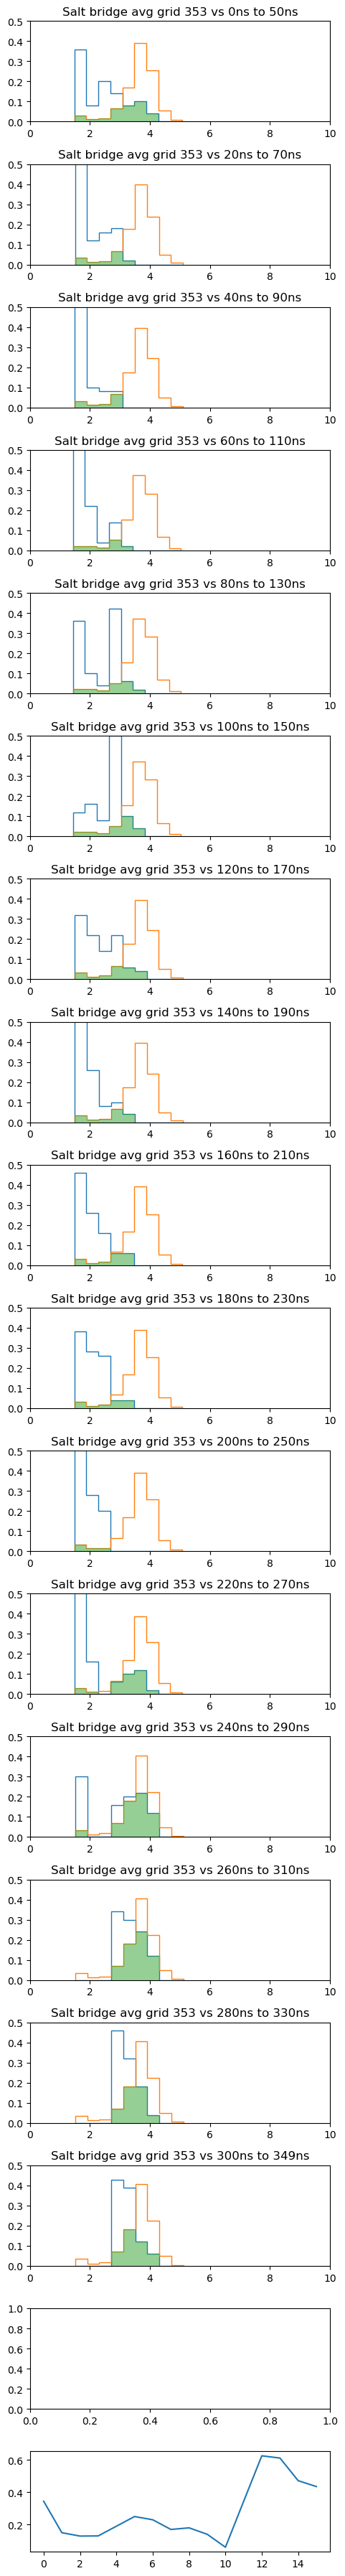

In [227]:
overlap_blocking(control_replica=control_replica,
                values1=salt_br_histos[control_replica],
                values2=salt_br_grid,
                xlim=(0,10),
                ylim=(0,0.5),
                title='Salt bridge avg',
                bin_sensitivity=0.4)

In [36]:
def plot_dist_and_stars(values_hist, atom_values, ax, bin_sensitivity):
    
    colors=['green', 'blue', 'pink']
    
    ## similar to claudia's method above, use np.histogram so that you can normalize 0-1. This just makes viz easier
    ## as it's exressed in a percent
    bin_min = np.min(np.concatenate([v for v in values_hist.values()]))
    bin_max = np.max(np.concatenate([v for v in values_hist.values()]))

    n=0
    for name,value in values_hist.items():
        height, bin_edges = np.histogram(value, bins=np.arange(bin_min, bin_max, bin_sensitivity))
        height = height/height.sum()
        ax.stairs(height,bin_edges,fill=True, alpha=0.1, color=colors[n])
        ax.stairs(height,bin_edges, color=colors[n])
        
        n=n+1
        

    for name,value in atom_values.items():
        ax.scatter(value, 0.3, marker='*', s = 200, linewidth=0.5, edgecolor='black',label=name)
    

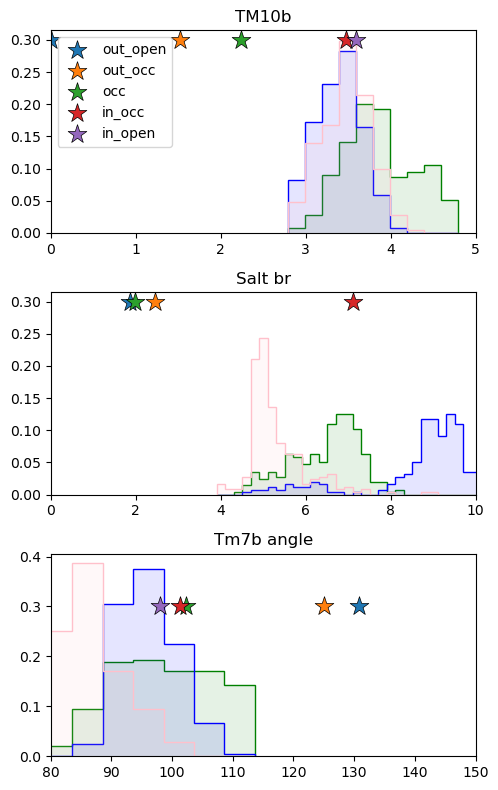

In [37]:
f,ax=plt.subplots(nrows=3,ncols=1,figsize=(5,8))
ax=np.ravel(ax)
plot_dist_and_stars(values_hist=tm10_histos,
                    atom_values=tm10_atom,
                    ax=ax[0],
                    bin_sensitivity=0.2)

ax[0].set_xlim(0,5)
ax[0].set_ylim(0)
ax[0].legend()
ax[0].set_title('TM10b')





plot_dist_and_stars(values_hist=salt_br_histos,
                    atom_values=salt_br_atom,
                    ax=ax[1],
                    bin_sensitivity=0.2)
ax[1].set_xlim(0,10)
ax[1].set_ylim(0)
ax[1].set_title('Salt br')





plot_dist_and_stars(values_hist=tm7_histos,
                    atom_values=tm7_atom,
                    ax=ax[2],
                    bin_sensitivity=5)
ax[2].set_xlim(80,150)
ax[2].set_ylim(0)
ax[2].set_title('Tm7b angle')




plt.tight_layout()


# RMSD
[to the top](#top)

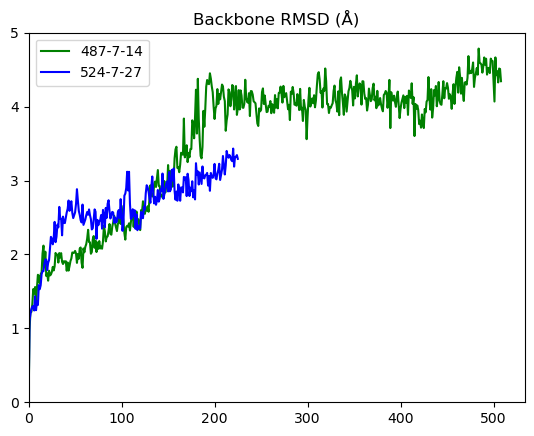

In [301]:
import MDAnalysis.analysis.rms
colors=['green', 'blue', 'pink']
fig, ax = plt.subplots(1,1)
n=0
for rep in uni_histos.keys():
    RMSD = MDAnalysis.analysis.rms.RMSD(uni_histos[rep], select = 'backbone', center = True)
    RMSD.run()
    rmsd=RMSD.rmsd
    ax.plot(rmsd[:,2], color=colors[n], label=rep)
    n=n+1



ax.set_ylim(0,5)
ax.set_xlim(0)
ax.set_title('Backbone RMSD (Å)')
ax.legend()

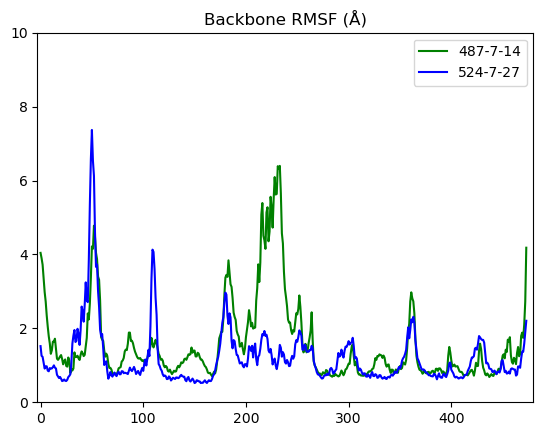

In [302]:
colors=['green', 'blue', 'pink']
fig, ax = plt.subplots(1,1)
n=0

for rep in uni_histos.keys():
    rmsf = np.loadtxt(f'{path_conds[cond]}/{rep}/rmsf.xvg')[:,1]
    plt.plot(rmsf*10, color=colors[n],label=rep)
    n=n+1

ax.set_ylim(0,10)
ax.set_xlim(-3,480)
ax.set_title('Backbone RMSF (Å)')
ax.legend()

In [176]:
atom_rmsds={}
for rep in uni_crystals_sims.keys():
    RMSD = MDAnalysis.analysis.rms.RMSD(uni_crystals_sims[rep], select = 'backbone', center = True)
    RMSD.run()
    rmsd=RMSD.rmsd
    atom_rmsds[rep]=rmsd[:,2]

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:710: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


In [276]:
print(path_conds[cond])

../../controls_string/inward_occluded/in_occ_high_string


# project onto other FES spaces

In [318]:
histo_conds

{'in_occ_high_string': ['552-10-06', '552-10-19', '552-10-23'],
 'in_occ_low_string': ['300-11-12', '551-11-16', '551-11-24'],
 'outward_open': ['552-1-2', '552-1-29', '552-2-1'],
 'occluded_full_symmetry': ['523-6-10', '525-6-19'],
 'occluded_PfHT': ['487-7-14', '524-7-27']}

In [357]:
control_replica='552-10-23'

In [421]:
indir = '../../../string/analysis/textfiles_out/not_gates_for_MSM/MSM_files/'
F_MSM = np.load(f'{indir}/influx_apo_gate_CV.TM10b-RMSD_TM7-angle.F_MSM.npy')
extent_MSM = np.load(f'{indir}/influx_apo_gate_CV.TM10b-RMSD_TM7-angle.extent_MSM.npy')

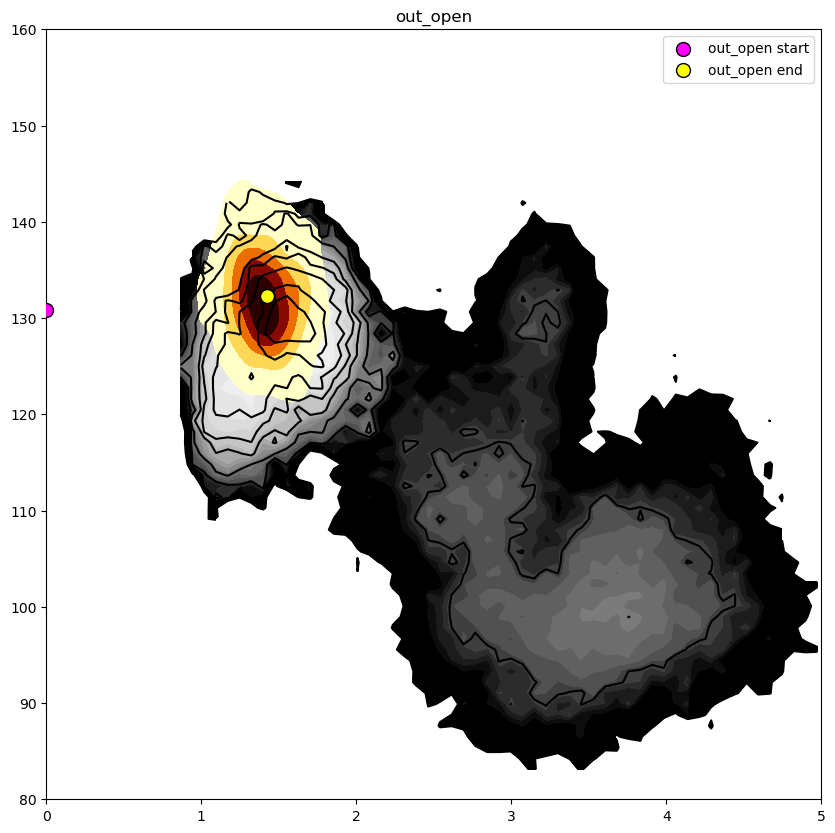

In [426]:
f,ax=plt.subplots(1,1,figsize=(10,10))

xlim=(0,5)
ylim=(80,160)


levelsf=np.linspace(0,15,30)
levels=[0,0.5,1,2,3,4,6,8,15]

ax.contourf(F_MSM, extent=extent_MSM,
            levels=levelsf,
           vmin=0,vmax=10,cmap='Greys' )
ax.contour(F_MSM, extent=extent_MSM, 
          levels=levels,
          vmin=0,vmax=10, colors='black')


'''
ax.scatter(tm10_histos[control_replica][0], tm7_histos[control_replica][0],c='magenta',\
           edgecolor='black', s=100, zorder=3,label=f'{control_replica} start')
ax.scatter(tm10_histos[control_replica][-1], tm7_histos[control_replica][-1],c='yellow', \
           edgecolor='black', s=100, zorder=3, label=f'{control_replica} end')

for name in uni_crystals_strs:
    ax.scatter(tm10_atom[name], tm7_atom[name], s = 200, zorder=5, edgecolor='black', label=name)
    
sns.kdeplot(tm10_histos[control_replica],y=tm7_histos[control_replica],ax=ax,shade=True,cmap='afmhot_r', levels=6)

'''
#uncomment if you want to check out OG atom sims
control_replica='out_open'
sns.kdeplot(tm10_atom[control_replica],y=tm7_atom[control_replica],\
ax=ax,shade=True,cmap='afmhot_r', levels=6)

ax.scatter(tm10_atom[control_replica][0], tm7_atom[control_replica][0],c='magenta',\
           edgecolor='black', s=100, zorder=3,label=f'{control_replica} start')
ax.scatter(tm10_atom[control_replica][-1], tm7_atom[control_replica][-1],c='yellow', \
           edgecolor='black', s=100, zorder=3, label=f'{control_replica} end')



ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title(control_replica)
ax.legend()

In [412]:
tm10_atom

{'out_open': array([0.]),
 'out_occ': array([1.51938313]),
 'occ': array([2.24380661]),
 'in_occ': array([3.47338134]),
 'in_open': array([3.59669941])}

In [399]:
darko_lda_histos_cv1={}
darko_lda_histos_cv2={}

for histo in histo_conds[cond]:
    cv1, cv2 = get_weighted_cv_dist(uni_histos[histo])
    darko_lda_histos_cv1[histo]=cv1
    darko_lda_histos_cv2[histo]=cv2

darko_lda_atom_cv1 = {}
darko_lda_atom_cv2 = {}

for sim in uni_crystals_strs.keys():
    cv1,cv2 = get_weighted_cv_dist(uni_crystals_sims[sim])
    darko_lda_atom_cv1[sim]=cv1
    darko_lda_atom_cv2[sim]=cv2

In [406]:
indir = '../../../string/analysis/textfiles_out/not_gates_for_MSM/MSM_files/'
F_MSM = np.load(f'{indir}/influx_apo_gate_CV.lda_cvs.F_MSM.npy')
extent_MSM = np.load(f'{indir}/influx_apo_gate_CV.lda_cvs.extent_MSM.npy')

control_replica = '552-10-23'

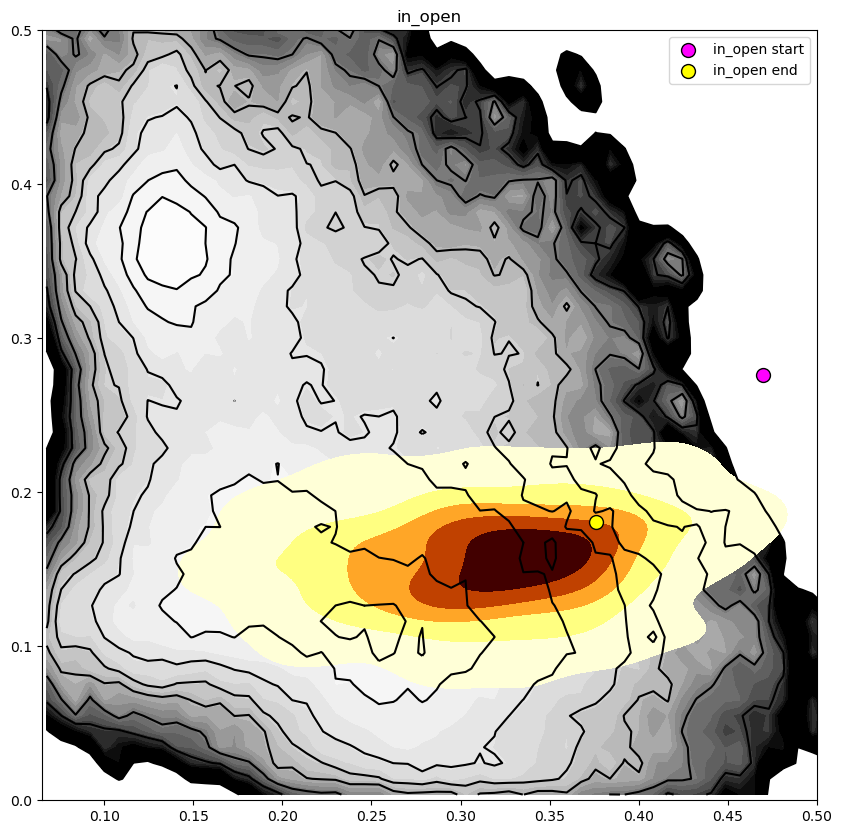

In [407]:
f,ax=plt.subplots(1,1,figsize=(10,10))

xlim=(0.065,0.5)
ylim=(0,0.5)


levelsf=np.linspace(0,15,30)
levels=[0,0.5,1,2,3,4,6,8,15]

ax.contourf(F_MSM, extent=extent_MSM,
            levels=levelsf,
           vmin=0,vmax=10,cmap='Greys' )
ax.contour(F_MSM, extent=extent_MSM, 
          levels=levels,
          vmin=0,vmax=10, colors='black')



ax.scatter(darko_lda_histos_cv1[control_replica][0], darko_lda_histos_cv2[control_replica][0],c='magenta',\
           edgecolor='black', s=100, zorder=3,label=f'{control_replica} start')
ax.scatter(darko_lda_histos_cv1[control_replica][-1], darko_lda_histos_cv2[control_replica][-1],c='yellow', \
           edgecolor='black', s=100, zorder=3, label=f'{control_replica} end')

for name in uni_crystals_strs:
    ax.scatter(darko_lda_atom_cv1[name], darko_lda_atom_cv2[name], s = 200, zorder=5, edgecolor='black', label=name)
    

sns.kdeplot(darko_lda_histos_cv1[control_replica],y=darko_lda_histos_cv2[control_replica],\
ax=ax,shade=True,cmap='afmhot_r', levels=6)


'''
#uncomment if you want to check out OG atom sims
control_replica='in_occ'
sns.kdeplot(darko_lda_atom_cv1[control_replica],y=darko_lda_atom_cv2[control_replica],\
ax=ax,shade=True,cmap='afmhot_r', levels=6)

ax.scatter(darko_lda_atom_cv1[control_replica][0], darko_lda_atom_cv2[control_replica][0],c='magenta',\
           edgecolor='black', s=100, zorder=3,label=f'{control_replica} start')
ax.scatter(darko_lda_atom_cv1[control_replica][-1], darko_lda_atom_cv2[control_replica][-1],c='yellow', \
           edgecolor='black', s=100, zorder=3, label=f'{control_replica} end')

'''


ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title(control_replica)
ax.legend()

In [12]:
u = uni_crystals_sims['out_open']

In [23]:
arg = u.select_atoms('resid 152 and name NE HE NH1 NH2 HH11 HH12 HH21 HH22')
glu = u.select_atoms('resid 394 and name OE1 OE2')

In [28]:
salt_br_histos_all_dists = salt_br_histos

In [31]:
salt_br_histos

{'552-10-06': array([5.25090116, 4.90202568, 5.0781253 , 5.50624294, 5.64462344,
        4.81484741, 4.82692765, 5.48472698, 5.99113294, 4.86217546,
        5.13230956, 5.03151221, 4.93075739, 5.16523386, 4.91449853,
        5.17899471, 4.83855382, 4.80166876, 4.85445726, 4.51534802,
        4.80366763, 4.55462814, 4.44875921, 4.78093731, 4.65965509,
        4.92905167, 4.60034938, 6.16414276, 6.04831661, 6.19967289,
        7.48798508, 6.57813771, 7.72408903, 7.27434821, 7.07994509,
        5.64130912, 5.45595919, 6.74376793, 6.98319255, 6.76234018,
        7.3412631 , 7.40049568, 6.65835264, 5.81718234, 5.7299254 ,
        5.56586461, 5.78186854, 6.20536201, 6.95125386, 5.75064918,
        5.09344966, 5.73548111, 5.51125564, 5.7856963 , 5.5981061 ,
        5.31651063, 5.98252389, 6.22585896, 7.10102873, 7.32311852,
        7.73781084, 7.43264395, 8.14856053, 7.31632201, 7.1930296 ,
        7.09919587, 7.60854725, 7.00513986, 7.858119  , 7.0089361 ,
        6.92159643, 7.46263782, 7.2

In [60]:
with open('../../../string/analysis/grid_label_coord_dict_influx_BFRU.txt','r') as inf:
    dict_from_file = eval(inf.read())

In [62]:
np.mean(dict_from_file[grid_num_conds[cond]][0:2])

1.2757870277777776

# distances to sugar!
I copied this from the string script

In [98]:
dists_d = {}

res_l = [166, 287, 288, 293, 324, 391]
#bfru = histo_823.select_atoms('resname BFRU')
title_d = {166:'Q166-OH1', 293:'N293-OH4',  324:'N324-OH6', 391:'S391-OH1', 287:'Q287-OH3', 288:'Q288-OH3'}
bfru_sel = {293:'and name O4 HO4', 166: 'and name O1 HO1', \
            391:'and name O1 HO1', 324:'and name O6 HO6', 287: 'and name O3 HO3', 288:'and name O3 HO3'}

for res in res_l:
    binding_res = u.select_atoms(f'resid {res-6}')
    bfru = u.select_atoms(f'resname BFRU {bfru_sel[res]}')
    print(binding_res.resnames[0], binding_res.resids[0]+6)
    dists = []
    for ts in u.trajectory:
        temp = np.min(d.distance_array(binding_res.positions, bfru.positions))
        dists.append(temp)

    #dists_d[res] = [np.mean(np.array(dists)), np.std(np.array(dists))]
    dists_d[title_d[res]] = np.array(dists)

GLN 166


ValueError: zero-size array to reduction operation minimum which has no identity

Text(0, 0.5, 'Minimum distance to sugar (Å) ')

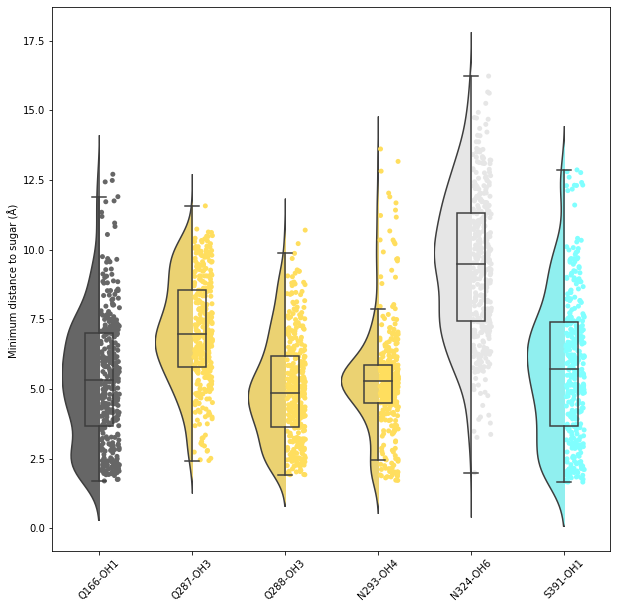

In [88]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
color_l = ['#666666','#FFDE5E','#FFDE5E','#FFDE5E', '#E6E6E6', '#80FFFF']
df = pd.DataFrame(dists_d)

p2 = sns.violinplot(data=df, palette = color_l, inner = None, scale = 'width')
for violin in p2.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))

sns.boxplot(data = df, saturation=1, showfliers=False,
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax, zorder =3)
old_len_collections = len(p2.collections)


sns.stripplot(data=df, dodge=False, ax=ax, palette = color_l)

for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0.12, 0]))

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.tick_params(axis='x', rotation=45)

ax.set_ylabel('Minimum distance to sugar (Å) ')


In [89]:
dists=[]
for ts in u.trajectory:
    y296=u.select_atoms('resid 290')
    h386=u.select_atoms('resid 380')
    dists.append(np.min(d.distance_array(y296.positions, h386.positions)))

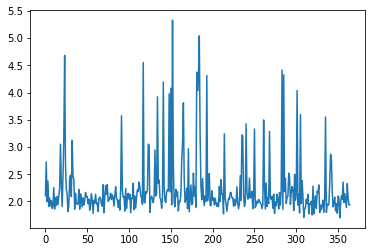

In [90]:
plt.plot(dists)